In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from sklearn import svm
import sklearn, sklearn.preprocessing
from sklearn.decomposition import PCA

In [33]:
class LinearSVM:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization):
        size = len(dataset[0])-1
        n = len(dataset)
        w = np.ones(size) #1/size * 
        
        w_norms = []
        
        for i in range(epochs):
            
            np.random.shuffle(dataset)
            X = dataset[:,:-1]
            Y = dataset[:,-1]
            X = sklearn.preprocessing.StandardScaler().fit_transform(X)
            
            
            for j in range(len(dataset)):
                #learning_rate = 1/ np.sqrt(j)
                x = X[j]                
                y = Y[j]
        
                ywx = y * w.dot(x) 
                    
                if ywx < 1:
                    gradient = (2 * regularization * w) / n - y*x
                else:
                    gradient = (2 * regularization * w) / n
                
                w = w - learning_rate * gradient
            
            w_norms.append(np.linalg.norm(w))
        
        return w, w_norms
        
    def predict(dataset,w):
        y = np.array(len(dataset)) 
        dataset = dataset[:,:-1]
        
        for i in range(len(dataset)):
            y[i] = np.dot(dataset[i],w)
        return y

def accuracy(y,y_pred):
    return sum(y == y_pred)/len(y)
    
    
def calculate_exact_w(dataset, regularization):
    # set initial w0
    size = len(dataset[0])-1
    w0 = (1/size) * np.ones(size) #

    # define the constraint
    con = {'type': 'ineq', 'fun': lambda w : 1/regularization - np.linalg.norm(w)}

    # optimize target function using scipy.optimize.minimize
    res = minimize(target_func, x0=w0, args=(dataset), constraints=con, method='SLSQP') #

    return res.x


def target_func(w, data ):
    f = 0
    for i in range(len(data)):
        f += max(0, 1 - data[i][-1] * np.dot(w, data[i][0:-1]))

    return f

In [34]:
#read data
data = pd.read_csv('toydata_tiny.csv').to_numpy()

#add one to each feature vector
#data = np.insert(data, obj = 4, values = np.ones(len(data)), axis = 1)

# shuffle along the first axis of array
#np.random.shuffle(data)

In [35]:
mySVM = LinearSVM()
regularization = 0.01
learning_rate = 0.001
epochs = 400
w, w_norms = mySVM.fit(data,learning_rate,epochs,regularization)
print(w)
print(np.linalg.norm(w))

w_exact = calculate_exact_w(data,regularization)
print(w_exact)
print(np.linalg.norm(w_exact))


[ 2.62104076 -0.73694141]
2.722670990137698
[ 1.36799416 -2.29449898]
2.6713542623057243


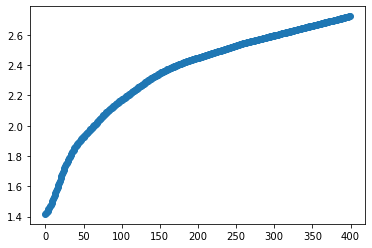

In [36]:
xs = range(epochs)
plt.scatter(xs, w_norms)
#plt.xlim([0,50])
plt.show()

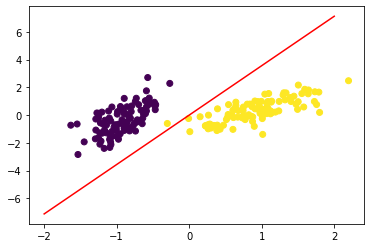

In [37]:
X = data[:,:-1]
Y = data[:,-1]
X = sklearn.preprocessing.StandardScaler().fit_transform(X)


plt.scatter(X[:,0],X[:,1], c = Y)
x = np.linspace(-2,2,100)
y = -w[0]*x/w[1]
plt.plot(x, y, c = 'r')

In [38]:
data = np.load("mnist.npz")

In [39]:
train = data["train"].T
train_labels = data["train_labels"][0]

test = data["test"].T
test_labels = data["test_labels"][0]

In [40]:
class LinearSVM_MC:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization, n_class):
        size = len(dataset[0])-1
        n = len(dataset)
        W = np.random.rand(size, n_class)
        
        w_norms = []
        
        for i in range(epochs):
            np.random.shuffle(dataset)
            for j in range(len(dataset)):
                x = dataset[j,:-1]
                y = dataset[j,-1]
                gradient = np.zeros([size, n_class])
        
                temp, k = mc_hinge(W, x, y)
                    
                if temp > 0:
                    
                    gradient[:,y] = -x

                    gradient[:,k] = x
                    
                
                W = W - learning_rate * (gradient + (2 * regularization * W) / n)
                #W = regularization * W/n - gradient
                
            w_norms.append(np.linalg.norm(W, axis=0))
            
        w_norms = np.array(w_norms)
        return W, w_norms
        
    def predict(self, dataset, W):
        y = np.array(len(dataset)) 
        dataset = dataset[:,:-1]

        for i in range(len(dataset)):
            y[i] = np.argmax(np.dot(dataset[i],W.T))
        return y

def mc_hinge(W,x,y):

    '''
    w_i - vector of weights of the SVM for the class i; W has |features| rows and |classes| columns
    x - features of a sample
    y - label of a sample
    loss = max{0, max(w_j*x - w_y*x)}, j={0,...,|classes|-1}, j!=y
    '''

    n_features, n_class = np.shape(W)
    wyx = W[:,y].dot(x)
    max_dif = - np.inf
    ind_j = 0

    for j in [i for i in range(n_class) if i != y]:
        wjx = W[:,j].dot(x)
        if wjx > max_dif:
            max_dif = wjx
            ind_j = j

    max_dif -= wyx

    if max_dif > 0:
        return 1 + max_dif, ind_j
    else:
        return 0, -1

In [41]:
data = pd.read_csv('iris.data').to_numpy()

features = data[:,:4]
features = sklearn.preprocessing.StandardScaler().fit_transform(features)
features = sklearn.preprocessing.normalize(features)
pca = PCA(n_components = 2) 
features = pca.fit_transform(features) 

labels_dict = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
labels = np.array([[labels_dict[x]] for x in data[:,4]])
labels2 = np.array([labels_dict[x] for x in data[:,4]])
#data[:,-1] = labels

combined = np.concatenate((features, labels), axis=1, dtype = object) 

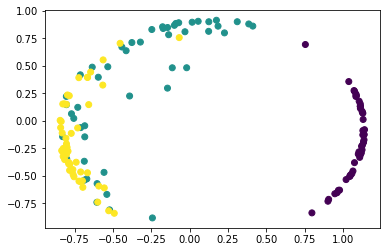

In [42]:
plt.scatter(combined[:,0], combined[:,1], c = labels)

In [43]:
mySVM = LinearSVM_MC()
regularization = 0.9
learning_rate = 0.01
epochs = 1000
W, norms = mySVM.fit(combined,learning_rate,epochs,regularization,n_class=3)

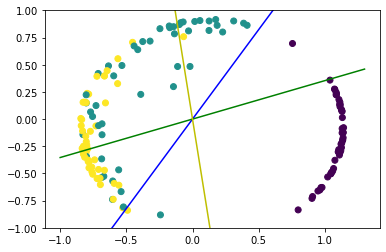

In [44]:
X = combined[:,:-1]
Y = combined[:,-1]

plt.scatter(X[:,0],X[:,1], c = Y)
x = np.linspace(-1,1.3,100)

w = W[:,0]
y = -w[0]*x/w[1]
plt.plot(x, y, c = 'b') # class 0(blue) vs rest

w = W[:,1]
y = -w[0]*x/w[1]
plt.plot(x, y, c = 'g') # class 1(green) vs rest

w = W[:,2]
y = -w[0]*x/w[1]
plt.plot(x, y, c = 'y') # class 2(yellow) vs rest


plt.ylim([-1, 1])
plt.show()

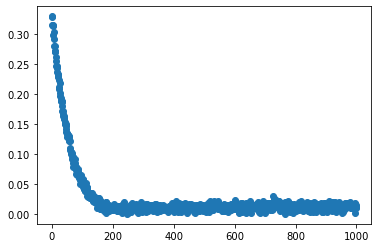

In [31]:
xs = range(epochs)
plt.scatter(xs, norms[:,2])
plt.show()